# Explore Daymet climate data around Clear Lake Reservoir. 

## We will be using the OPeNDAP (Open-source Project for a Network Data Access Protocol) endpoint and xarray to access the "Daily Surface Weather Data on a 1-km Grid for North America, Version 3" data product

## Research questions: Knowing Tucker fire began on July 29, 2019,
## 1) How was August 1, 2019 air temperature look like in the Clear Lake Reservoir region? 
## 2) How was the average air temperature around the reservoir region on August 1, 2019 compared to the average air temperature around the reservoir region on August 1 in the past 10-year (2009-2018)?

### THREDDS Data Server catalog page for this product
### OPeNDAP endpoint url: 
### https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml (xarray can directly read from this url)

## This is based on Tuesday Tutorial 2 and 3

## Sep 3, 2020: 2nd Version 
### - Revise the analysis region to match with MODIS analysis. 
### - Add computation of region-wide statistics (hold time constant), and create a time series of stat summary. 

In [48]:
# To get started, import xarray and other libraries we'll be using in this notebook...

import xarray as xr
import pandas as pd
import numpy as np

# for working with geospatial data
import geopandas as gpd
from pyproj import CRS
from shapely import geometry

# for plotting, import matplotlib.pyplot
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

## Use xarray to open the dataset at this OPeNDAP endpoint

In [49]:
# Open DayMet Dataset
ds = xr.open_dataset("https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml")
ds
type(ds)

xarray.core.dataset.Dataset

In [50]:
# Get the coordinate reference system used by DayMet
daymet_crs = CRS.from_cf(ds.lambert_conformal_conic.attrs)

## Make our Clear Lake Reservoir bounding box and use it to subset the DayMet dataset:

In [51]:
# Specify the region we want to look at with DayMet (lon_min, lat_min, lon_max, lat_max)
# and the coordinate system we are providing the bounding box coordinates in (epsg:4326)
# finally, reproject our bounding box polygon into this new coordinate system (Lambert Conformal Conic)
bounding_box = gpd.GeoSeries(geometry.box(-121.3, 41.95, -121.0, 41.75), crs='epsg:4326').to_crs(daymet_crs)

# Select this region from our DayMet Dataset
clearLake = ds.sel(x = slice(bounding_box.bounds.minx[0], bounding_box.bounds.maxx[0]),
                 y = slice(bounding_box.bounds.maxy[0], bounding_box.bounds.miny[0]))

In [52]:
clearLake

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 29, y: 26)
Coordinates:
  * x                        (x) float32 -1671250.0 -1670250.0 ... -1643250.0
  * y                        (y) float32 155000.0 154000.0 ... 131000.0 130000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

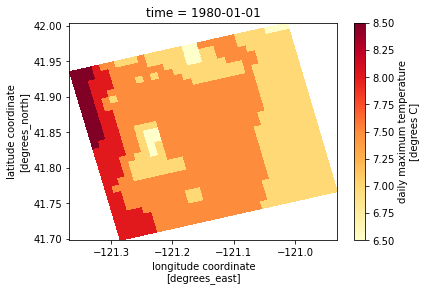

In [53]:
# **Plot tmax for the first day** to make sure we're looking at Clear Lake.
clearLake.isel(time=0).tmax.plot(x='lon', y='lat', cmap='YlOrRd')

### We want to look at values only for August 1st tmax. We can do this with a combination of boolean (True/False) arrays and the .sel() method.

In [54]:
# An expression like this will produce a boolean DataArray, only True where the month is = 8 (August)

clearLake['time.month'] == 8

<xarray.DataArray 'month' (time: 14600)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31

In [55]:
# We can combine these expressions with operators like & (and)

(clearLake['time.month'] == 8) & (clearLake['time.day'] == 1)

<xarray.DataArray (time: 14600)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31

In [56]:
# And finally used them with an expression within .sel() to get values that only correspond with "True"
# Each layer is August 1 data for each year (total 40 years)
clearLake_august1 = clearLake.sel(time=( (clearLake['time.month'] == 8) & (clearLake['time.day'] == 1) ) )
clearLake_august1

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 40, x: 29, y: 26)
Coordinates:
  * x                        (x) float32 -1671250.0 -1670250.0 ... -1643250.0
  * y                        (y) float32 155000.0 154000.0 ... 131000.0 130000.0
  * time                     (time) datetime64[ns] 1980-08-01 ... 2019-08-01
    lat                      (y, x) float32 41.93208 41.934467 ... 41.76993
    lon                      (y, x) float32 -121.360245 ... -120.938866
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 -32767
    yearday                  (time) int16 213 212 212 212 ... 213 212 212 212
    time_bnds                (time, nv) datetime64[ns] 1980-08-01 ... 2019-08-02
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

In [57]:
# Select 10-year historial data from 2009-2018. This data set has all parameters. 
clearLake_aug1_historic = clearLake_august1.sel(time = (clearLake_august1['time.year'] > 2008) & (clearLake_august1['time.year'] < 2019)  )
clearLake_aug1_all = clearLake_august1.sel(time = (clearLake_august1['time.year'] > 2008))

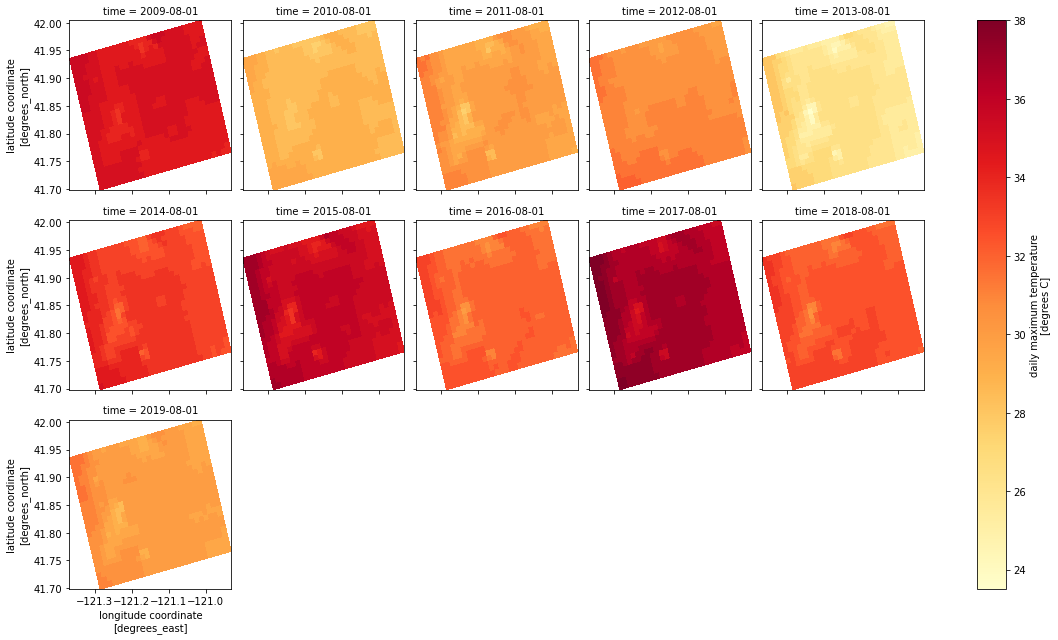

In [58]:
# In this plot statement, we use col='time' to tell xarray that we want an individual plot for each time value
# and col_wrap=5 to tell xarray to plot 5 of these in a row, then wrap around and keep plotting...\
# We define a new dataset to hold only tmax
Tmax_historic = clearLake_aug1_all.tmax
Tmax_historic.plot(x='lon', y='lat', col='time', col_wrap=5, cmap='YlOrRd')
#clearLake_aug1_historic.tmax.plot(x='lon', y='lat', col='time', col_wrap=5, cmap='YlOrRd')

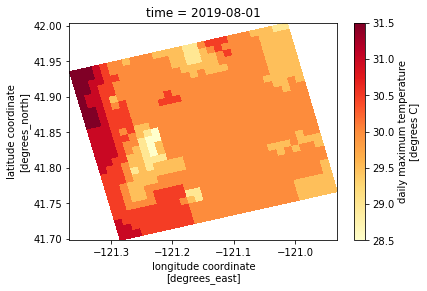

In [59]:
# Next, plot the tmax map for August 1, 2019 - condition during the Tucker fire. 

clearLake_aug1_2019 = clearLake_august1.sel(time = (clearLake_august1['time.year'] == 2019) )
clearLake_aug1_2019.tmax.plot(x='lon', y='lat', cmap='YlOrRd')

In [60]:
## Compute summary statistics across space (hold time constant)
## Need to learn how to loop through xarray! Now, use simple way to extract data. 


medianTmax_2009 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2009) ).median()
meanTmax_2009 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2009) ).mean()

medianTmax_2010 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2010) ).median()
meanTmax_2010 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2010) ).mean()
    
medianTmax_2011 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2011) ).median()
meanTmax_2011 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2011) ).mean()

medianTmax_2012 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2012) ).median()
meanTmax_2012 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2012) ).mean()

medianTmax_2013 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2013) ).median()
meanTmax_2013 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2013) ).mean()

medianTmax_2014 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2014) ).median()
meanTmax_2014 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2014) ).mean()

medianTmax_2015 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2015) ).median()
meanTmax_2015 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2015) ).mean()

medianTmax_2016 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2016) ).median()
meanTmax_2016 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2016) ).mean()

medianTmax_2017 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2017) ).median()
meanTmax_2017 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2017) ).mean()

medianTmax_2018 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2018) ).median()
meanTmax_2018 = Tmax_historic.sel(time = (Tmax_historic['time.year'] == 2018) ).mean()

medianTmax_2019 = clearLake_aug1_2019.tmax.median()
meanTmax_2019   = clearLake_aug1_2019.tmax.mean()

###

medianTmax = np.array([medianTmax_2009, medianTmax_2010, medianTmax_2011, medianTmax_2012, medianTmax_2013, medianTmax_2014, medianTmax_2015, medianTmax_2016, medianTmax_2017, medianTmax_2018, medianTmax_2019])
meanTmax = np.array([meanTmax_2009, meanTmax_2010, meanTmax_2011, meanTmax_2012, meanTmax_2013, meanTmax_2014, meanTmax_2015, meanTmax_2016, meanTmax_2017, meanTmax_2018, meanTmax_2019])
print("Region-wide median Tmax for August 1 from 2009-2019 : ", medianTmax)
print("Region-wide mean Tmax for August 1 from 2009-2019 : ", meanTmax)

Region-wide median Tmax for August 1 from 2009-2019 :  [35.  29.  30.  31.  26.5 33.5 35.5 32.  37.  32.5 30. ]
Region-wide mean Tmax for August 1 from 2009-2019 :  [34.74735  28.754642 29.95358  30.793104 26.249336 33.299072 35.66976
 31.959549 36.749336 32.492706 30.032494]


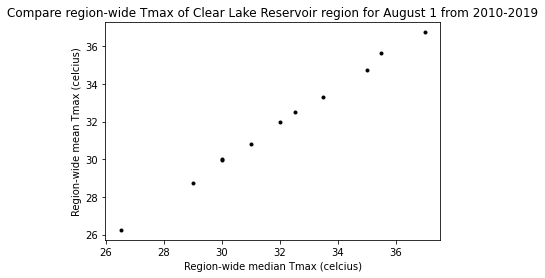

In [61]:
# Make a scatter plot comparing median and mean region-wide Tmax for August 1 from 2009 to 2019.
#plt.plot(medianTmax, meanTmax)

# set-up the plot
plt.xlabel('Region-wide median Tmax (celcius)')
plt.ylabel('Region-wide mean Tmax (celcius)')
plt.title('Compare region-wide Tmax of Clear Lake Reservoir region for August 1 from 2010-2019')
 
# plot sample data
plt.plot(medianTmax, meanTmax,'.k')

## Compute summary statistics across time only (mainstains spatial dimensions).

### So far, we have 10 time steps of tmax for Clear Lake August 1 conditions (10 years). Will find out the mean tmax (across time) for each grid => Base map for comparison with 2019 condition.

In [62]:
# Compute mean tmax across time for each grid - this will be the normal pattern of August 1 Tmax for the region.
clearLake_aug1_historic.tmax.mean('time')

<xarray.DataArray 'tmax' (y: 26, x: 29)>
array([[33.2 , 33.1 , 33.15, 32.65, 32.25, 31.95, 31.65, 31.5 , 31.65,
        31.75, 31.65, 31.5 , 31.45, 31.15, 31.15, 31.05, 31.05, 31.95,
        32.5 , 32.45, 32.3 , 31.95, 31.95, 31.8 , 31.55, 31.15, 31.15,
        31.  , 31.  ],
       [33.2 , 33.2 , 33.  , 32.7 , 32.35, 32.05, 31.75, 31.75, 31.75,
        31.75, 31.75, 31.75, 31.7 , 31.35, 31.15, 30.6 , 30.8 , 31.15,
        31.8 , 32.3 , 32.2 , 32.15, 31.95, 31.95, 31.75, 31.45, 31.4 ,
        31.2 , 31.3 ],
       [33.2 , 33.2 , 32.85, 32.6 , 32.35, 32.15, 31.75, 31.75, 31.75,
        31.75, 31.75, 31.75, 31.7 , 31.45, 31.2 , 30.5 , 31.05, 31.2 ,
        31.15, 31.95, 32.25, 32.2 , 32.15, 31.95, 31.95, 31.55, 31.5 ,
        31.45, 31.5 ],
       [33.2 , 33.15, 32.75, 32.45, 32.35, 32.05, 31.75, 31.75, 31.75,
        31.8 , 31.7 , 31.8 , 31.75, 31.7 , 31.35, 31.15, 31.45, 31.45,
        31.4 , 31.6 , 32.  , 32.15, 32.2 , 32.1 , 31.95, 31.75, 31.5 ,
        31.5 , 31.55],
       [33.15, 33.  , 32.65, 32.4 , 32.2 , 32.05, 31.8 , 31.75, 31.75,
        32.  , 31.8 , 31.75, 31.95, 31.8 , 31.65, 31.45, 31.65, 31.55,
        31.6 , 31.6 , 31.85, 31.95, 32.2 , 32.15, 31.95, 31.85, 31.5 ,
        31.55, 31.55],
...
       [32.65, 32.7 , 32.3 , 32.  , 32.15, 32.25, 32.6 , 32.6 , 32.55,
        32.55, 30.95, 31.1 , 32.15, 32.2 , 32.25, 32.25, 32.25, 32.3 ,
        32.2 , 32.15, 32.15, 32.15, 32.  , 31.95, 31.85, 31.95, 31.95,
        31.9 , 31.8 ],
       [32.8 , 32.8 , 32.8 , 32.7 , 32.6 , 32.6 , 32.7 , 32.6 , 32.55,
        32.4 , 31.55, 31.1 , 32.15, 32.2 , 32.3 , 32.3 , 32.35, 32.3 ,
        32.15, 32.15, 32.1 , 32.05, 32.  , 31.85, 31.8 , 31.8 , 31.8 ,
        31.8 , 31.7 ],
       [32.9 , 32.85, 32.85, 32.85, 32.75, 32.7 , 32.7 , 32.65, 32.55,
        32.5 , 32.3 , 32.1 , 32.2 , 32.3 , 32.3 , 32.35, 32.35, 32.25,
        32.15, 32.05, 32.05, 32.05, 32.  , 31.85, 31.8 , 31.8 , 31.8 ,
        31.8 , 31.55],
       [33.  , 32.95, 32.9 , 32.9 , 32.85, 32.7 , 32.7 , 32.65, 32.55,
        32.45, 32.35, 32.35, 32.3 , 32.3 , 32.35, 32.35, 32.3 , 32.2 ,
        32.2 , 32.05, 32.05, 32.1 , 32.  , 31.8 , 31.8 , 31.6 , 31.7 ,
        31.8 , 31.45],
       [33.1 , 33.  , 32.9 , 32.9 , 32.9 , 32.75, 32.7 , 32.65, 32.65,
        32.5 , 32.4 , 32.3 , 32.3 , 32.3 , 32.35, 32.35, 32.25, 32.2 ,
        32.2 , 32.05, 32.05, 32.05, 32.05, 31.85, 31.75, 31.55, 31.65,
        31.55, 31.35]], dtype=float32)
Coordinates:
  * x        (x) float32 -1671250.0 -1670250.0 ... -1644250.0 -1643250.0
  * y        (y) float32 155000.0 154000.0 153000.0 ... 131000.0 130000.0
    lat      (y, x) float32 41.93208 41.934467 41.936855 ... 41.767586 41.76993
    lon      (y, x) float32 -121.360245 -121.348015 ... -120.95108 -120.938866

## We can plot this mean tmax map and compare to 2019 condition during the fire. 

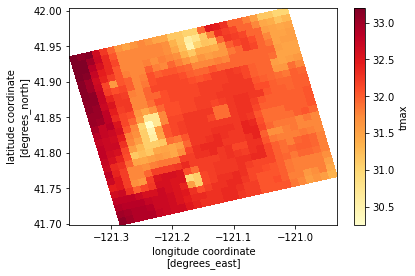

In [63]:
# First, plot the mean tmax map. 
# matplot colormap reference:  https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html

clearLake_aug1_historic.tmax.mean('time').plot(x='lon', y='lat', cmap='YlOrRd')

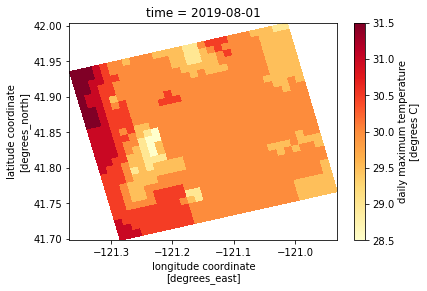

In [64]:
# Next, plot the tmax map for August 1, 2019 - condition during the Tucker fire. 

clearLake_aug1_2019 = clearLake_august1.sel(time = (clearLake_august1['time.year'] == 2019) )
clearLake_aug1_2019.tmax.plot(x='lon', y='lat', cmap='YlOrRd')


Text(0.5, 1.0, 'Tmax deviation (celcius) on Aug 1, 2019 compared to 10-year Tmax-average on Aug 1')

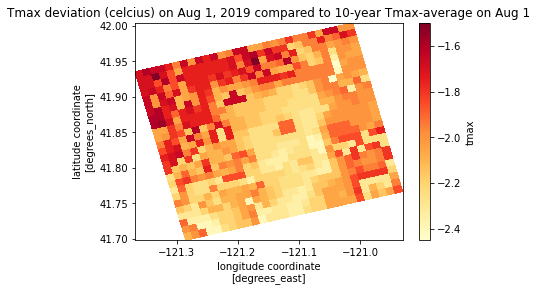

In [65]:
# Compute deviation of tmax for each grid, comparing 2019 to normal patter. 
# Plot the deviation map. 

tmax_deviation = clearLake_aug1_2019.tmax - clearLake_aug1_historic.tmax.mean('time')
tmax_deviation.plot(x='lon', y='lat', cmap='YlOrRd')
plt.title('Tmax deviation (celcius) on Aug 1, 2019 compared to 10-year Tmax-average on Aug 1')

In [66]:
# Readin MODIS Land Surface Temperature - Day time temperature from a csv file. 
# dayLST_file = pd.read_csv('\GEEcode\GEEout\temp_stats_dayLST_clear.csv')
dayLST = pd.read_csv('GEEcode/GEEout/temp_stats_dayLST_clear.csv')
print(type(dayLST))
print(dayLST.head(5))

<class 'pandas.core.frame.DataFrame'>
  system:index  LST_Day_1km_median  LST_Day_1km_stdDev  \
0   2009_01_01                 NaN                 NaN   
1   2009_01_02               -0.77            0.632075   
2   2009_01_03               -0.19            0.447617   
3   2009_01_04                 NaN                 NaN   
4   2009_01_05                 NaN                 NaN   

                             maxLST                             minLST  \
0                {LST_Day_1km=null}                 {LST_Day_1km=null}   
1  {LST_Day_1km=0.6300000000000523}  {LST_Day_1km=-2.1899999999999977}   
2  {LST_Day_1km=0.7100000000000364}  {LST_Day_1km=-1.2099999999999795}   
3                {LST_Day_1km=null}                 {LST_Day_1km=null}   
4                {LST_Day_1km=null}                 {LST_Day_1km=null}   

      modis_time  pixel_count  .geo  
0  1230768000000            0   NaN  
1  1230854400000           35   NaN  
2  1230940800000           25   NaN  
3  1231027200000

In [67]:
## Select only August 1 data.
# First, have to set up time index before querying for data on August 1. 

#dayLST_median = pd.DataFrame(dayLST[dayLST['system:index'] == '2009_01_02'])

clear_LST_day = dayLST.copy()
clear_LST_day['datetime'] = pd.to_datetime(clear_LST_day['system:index'], format = '%Y_%m_%d')
clear_LST_day.head(3)

,system:index,LST_Day_1km_median,LST_Day_1km_stdDev,maxLST,minLST,modis_time,pixel_count,.geo,datetime
0,2009_01_01,NaN,NaN,{LST_Day_1km=null},{LST_Day_1km=null},1230768000000,0,NaN,2009-01-01
1,2009_01_02,-0.77,0.632075,{LST_Day_1km=0.6300000000000523},{LST_Day_1km=-2.1899999999999977},1230854400000,35,NaN,2009-01-02
2,2009_01_03,-0.19,0.447617,{LST_Day_1km=0.7100000000000364},{LST_Day_1km=-1.2099999999999795},1230940800000,25,NaN,2009-01-03


## Here is how to make a query about date with panda Dataframe. 

In [68]:
## We don't need to create a new panda dataframe. It does not support & operation.

#this line does not work.  temp = pd.DataFrame((clear_LST_day[clear_LST_day["datetime"].dt.month==8]) & (clear_LST_day[clear_LST_day["datetime"].dt.day==1]) )
regionT = clear_LST_day[(clear_LST_day["datetime"].dt.month==8) &  (clear_LST_day["datetime"].dt.day==1)]
temp2 = clear_LST_day[clear_LST_day["datetime"].dt.month==8]  # Testing: temp2 creates a dataframe based on the query result. 
regionT.head(11)

,system:index,LST_Day_1km_median,LST_Day_1km_stdDev,maxLST,minLST,modis_time,pixel_count,.geo,datetime
212,2009_08_01,30.71,7.753927,{LST_Day_1km=52.59000000000003},{LST_Day_1km=27.170000000000016},1249084800000,31,NaN,2009-08-01
577,2010_08_01,31.77,5.872795,{LST_Day_1km=45.53000000000003},{LST_Day_1km=23.450000000000045},1280620800000,29,NaN,2010-08-01
942,2011_08_01,27.60,3.113418,{LST_Day_1km=35.110000000000014},{LST_Day_1km=24.57000000000005},1312156800000,30,NaN,2011-08-01
1308,2012_08_01,30.50,3.836273,{LST_Day_1km=41.97000000000003},{LST_Day_1km=26.49000000000001},1343779200000,34,NaN,2012-08-01
1673,2013_08_01,23.17,5.073486,{LST_Day_1km=35.710000000000036},{LST_Day_1km=22.27000000000004},1375315200000,5,NaN,2013-08-01
2038,2014_08_01,41.15,8.089590,{LST_Day_1km=49.57000000000005},{LST_Day_1km=25.690000000000055},1406851200000,23,NaN,2014-08-01
2403,2015_08_01,37.77,5.655267,{LST_Day_1km=46.97000000000003},{LST_Day_1km=27.470000000000027},1438387200000,35,NaN,2015-08-01
2760,2016_08_01,32.03,6.374077,{LST_Day_1km=47.670000000000016},{LST_Day_1km=27.150000000000034},1470009600000,26,NaN,2016-08-01
3125,2017_08_01,31.42,3.863775,{LST_Day_1km=42.53000000000003},{LST_Day_1km=28.950000000000045},1501545600000,38,NaN,2017-08-01
3490,2018_08_01,NaN,NaN,{LST_Day_1km=null},{LST_Day_1km=null},1533081600000,0,NaN,2018-08-01


## Next, add regional air Tmax median as another column in this dataframe. 
## First, convert a numpy array to a list. Then, add the list as another column in the dataframe. 

In [69]:
airTmax = medianTmax.tolist()
regionT['airTmax_median'] = airTmax
regionT

/opt/conda/envs/whw/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,system:index,LST_Day_1km_median,LST_Day_1km_stdDev,maxLST,minLST,modis_time,pixel_count,.geo,datetime,airTmax_median
212,2009_08_01,30.71,7.753927,{LST_Day_1km=52.59000000000003},{LST_Day_1km=27.170000000000016},1249084800000,31,NaN,2009-08-01,35.0
577,2010_08_01,31.77,5.872795,{LST_Day_1km=45.53000000000003},{LST_Day_1km=23.450000000000045},1280620800000,29,NaN,2010-08-01,29.0
942,2011_08_01,27.60,3.113418,{LST_Day_1km=35.110000000000014},{LST_Day_1km=24.57000000000005},1312156800000,30,NaN,2011-08-01,30.0
1308,2012_08_01,30.50,3.836273,{LST_Day_1km=41.97000000000003},{LST_Day_1km=26.49000000000001},1343779200000,34,NaN,2012-08-01,31.0
1673,2013_08_01,23.17,5.073486,{LST_Day_1km=35.710000000000036},{LST_Day_1km=22.27000000000004},1375315200000,5,NaN,2013-08-01,26.5
2038,2014_08_01,41.15,8.089590,{LST_Day_1km=49.57000000000005},{LST_Day_1km=25.690000000000055},1406851200000,23,NaN,2014-08-01,33.5
2403,2015_08_01,37.77,5.655267,{LST_Day_1km=46.97000000000003},{LST_Day_1km=27.470000000000027},1438387200000,35,NaN,2015-08-01,35.5
2760,2016_08_01,32.03,6.374077,{LST_Day_1km=47.670000000000016},{LST_Day_1km=27.150000000000034},1470009600000,26,NaN,2016-08-01,32.0
3125,2017_08_01,31.42,3.863775,{LST_Day_1km=42.53000000000003},{LST_Day_1km=28.950000000000045},1501545600000,38,NaN,2017-08-01,37.0
3490,2018_08_01,NaN,NaN,{LST_Day_1km=null},{LST_Day_1km=null},1533081600000,0,NaN,2018-08-01,32.5


## Finally, do a scatter plot of region median MODIS LST Day temperature  vs region median air Tmax for August 1 in each year. 
## Also do a time series of LST Day temp median and air Tmax median for August 1 from 2009 - 2019. 
## We are trying to see if we notice any difference in 2019, compared to 10-year historical pattern, due to the Tucker Fire. 

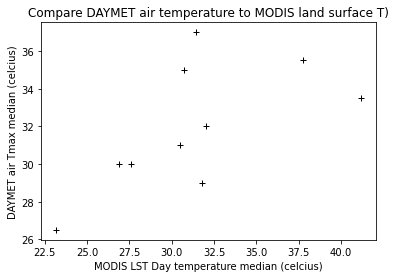

In [70]:
x = regionT['LST_Day_1km_median']
y = regionT['airTmax_median']
t = regionT['datetime'].dt.year

#regionT_2019 = regionT[(regionT["datetime"].dt.year==2019)
plt.plot(x, y,'k+')
plt.xlabel('MODIS LST Day temperature median (celcius)')
plt.ylabel('DAYMET air Tmax median (celcius)')
plt.title('Compare DAYMET air temperature to MODIS land surface T)')
plt.show()